# Machine Learning Model 
---

In [1]:
ticker = 'fb'

# Colors
lightblue = '#4ac2fb'
pinkyred = '#ff4e97'
black='#333333'

### Import Libraries 

In [2]:
import os
import warnings

import pandas as pd
import seaborn as sns
import numpy as np

from importlib import reload
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 227

warnings.filterwarnings('ignore')

### Import ARIMA, SARIMA Libraries

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

### Import Tensorflow Keras Libraries 

In [4]:
import tensorflow.keras as keras

from tensorflow.python.keras.optimizer_v2 import rmsprop
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model


from bayes_opt import BayesianOptimization
from functools import partial 

In [5]:
np.random.seed(66)

### Import Data

In [6]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

In [7]:
print(files)

['amzn.csv', 'msft.csv', 'fb.csv', 'tsla.csv', 'googl.csv', 'goog.csv', '.ipynb_checkpoints', 'aapl.csv']


---
# Baseline Model
- benchmark for comparing future more complex models
---

In [8]:
def baseline_model(stock):
    
    # turn into 0s and 1s
    Binary = lambda data: [1 if x > 0 else 0 for x in data] 
    
    # .randint(low,high,output size)
    pred = np.random.randint(0,2,len(stock))
    accuracy = accuracy_score(Binary(stock), pred)
    
    return accuracy

In [9]:
baseline_accuracy = baseline_model(stocks[ticker.lower()].Return)
print('Baseline Model Accuracy: {:.1f}%'.format(baseline_accuracy*100))

Baseline Model Accuracy: 50.8%


### Accuracy Distribution

In [10]:
baseline_preds = []
for i in range(1000):
    baseline_preds.append(baseline_model(stocks[ticker.lower()].Return))

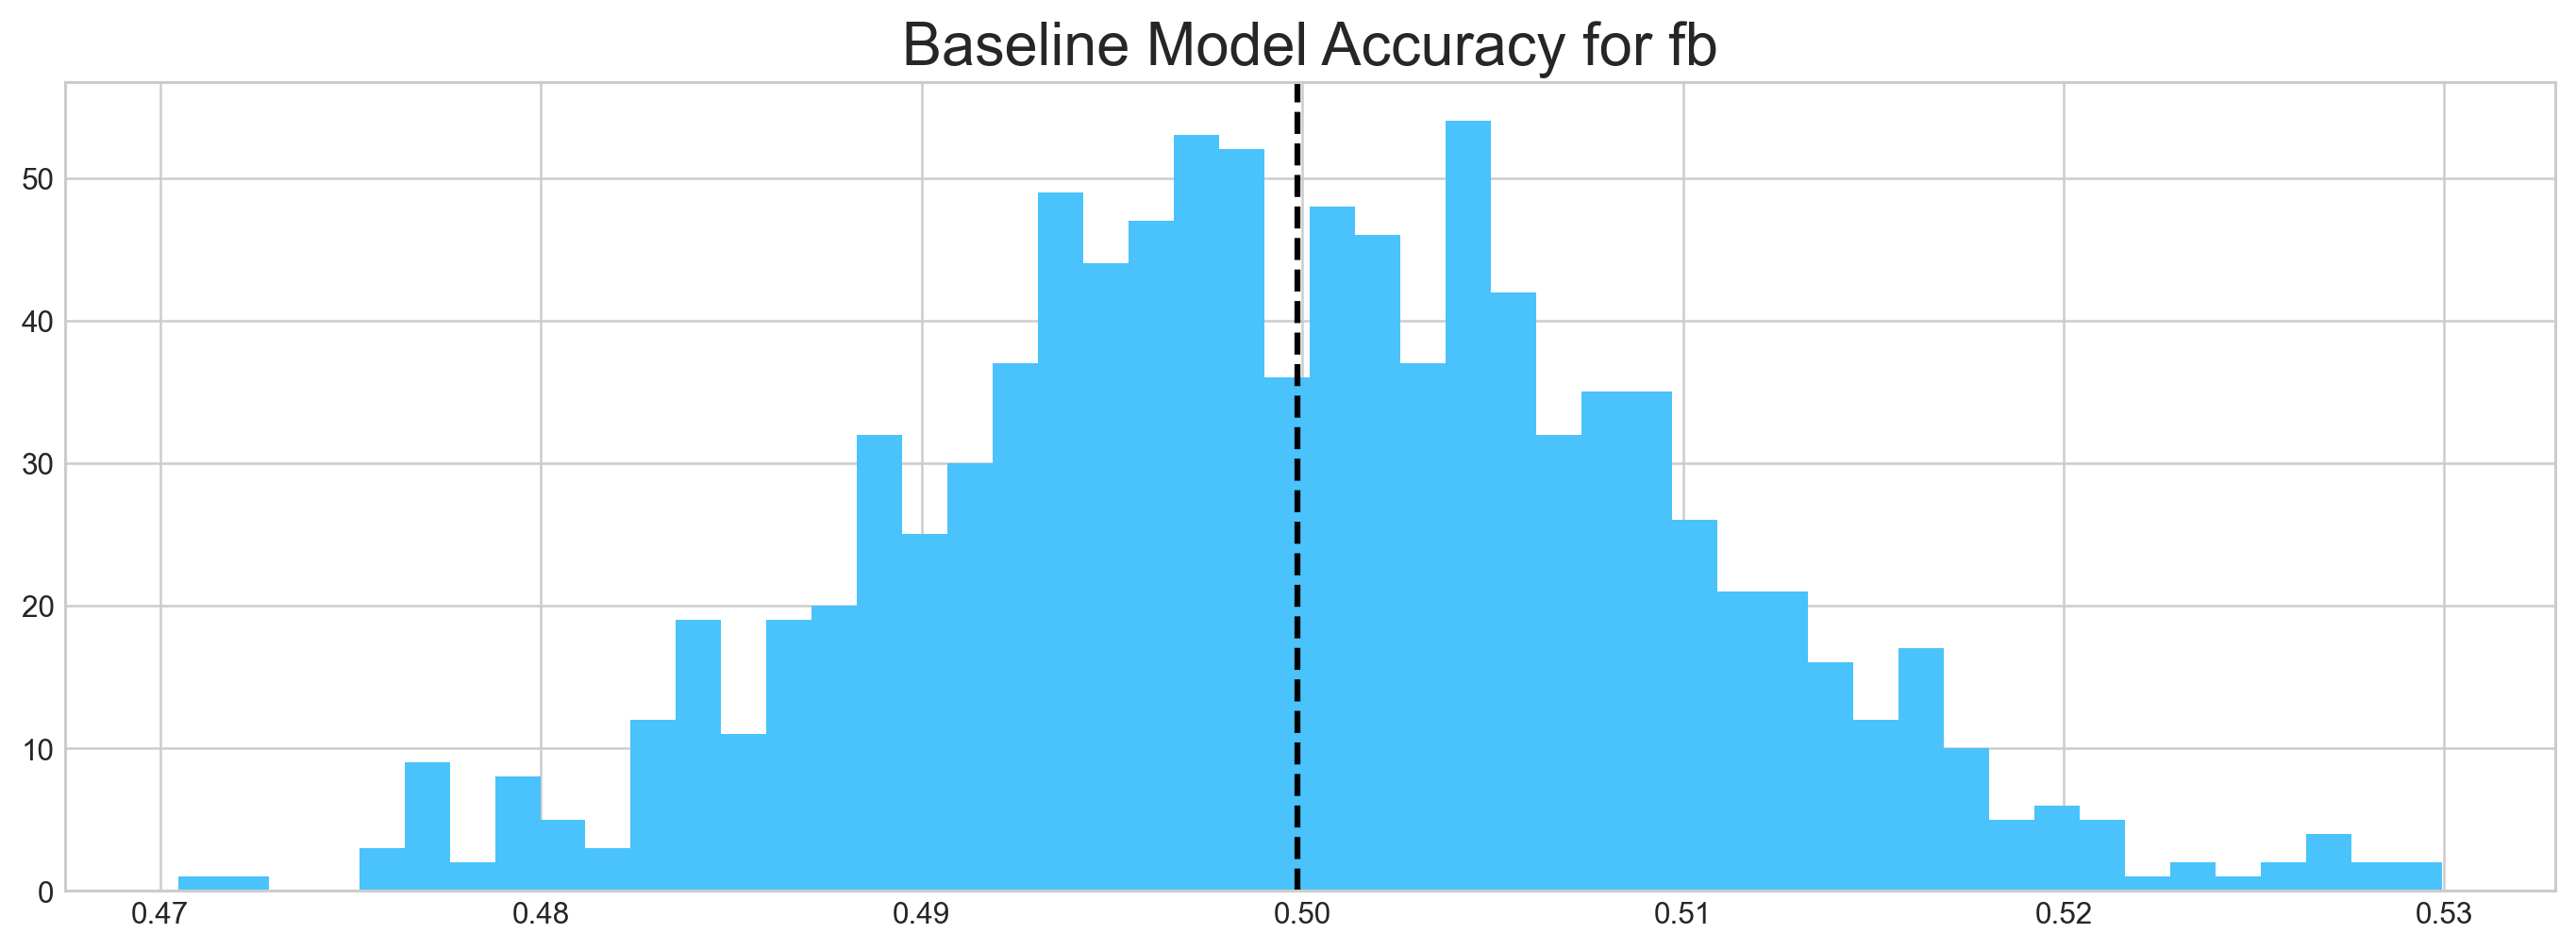

In [11]:
plt.figure(figsize=(15,5))
plt.style.use('seaborn-whitegrid')
plt.hist(baseline_preds, bins=50, facecolor=lightblue)

plt.title(f'Baseline Model Accuracy for {ticker}', fontsize=20)
plt.axvline(np.array(baseline_preds).mean(), c='k', ls='--', lw=2)
plt.show();

---
# [ARIMA](measurementsUsed/ARIMA.md)
#### AutoRegressive Integrated Moving Averate
- `p` = number of lags in the model
- `d` = degree of differencing -> aka number of times raw observations are differenced
- `q` = order of moving average -> moving average window size 
---

### Split Data for Training and Testing 

In [12]:
all_entries = stocks[ticker.lower()].shape[0]
last_252 = all_entries-253
last_600 = all_entries-600
test_600 = last_600-600
train_600 = test_600-600
print(f'{ticker.upper()} historical data contains {all_entries} entries')

FB historical data contains 2489 entries


In [13]:
test = list(stocks[ticker.lower()]['Return'][test_600:last_600].values)
train = list(stocks[ticker.lower()]['Return'][train_600:test_600].values)

### AutoCorrelation Function
- how time series data points correlate to one another 
- ignore first value -> comparing itself to only itself 

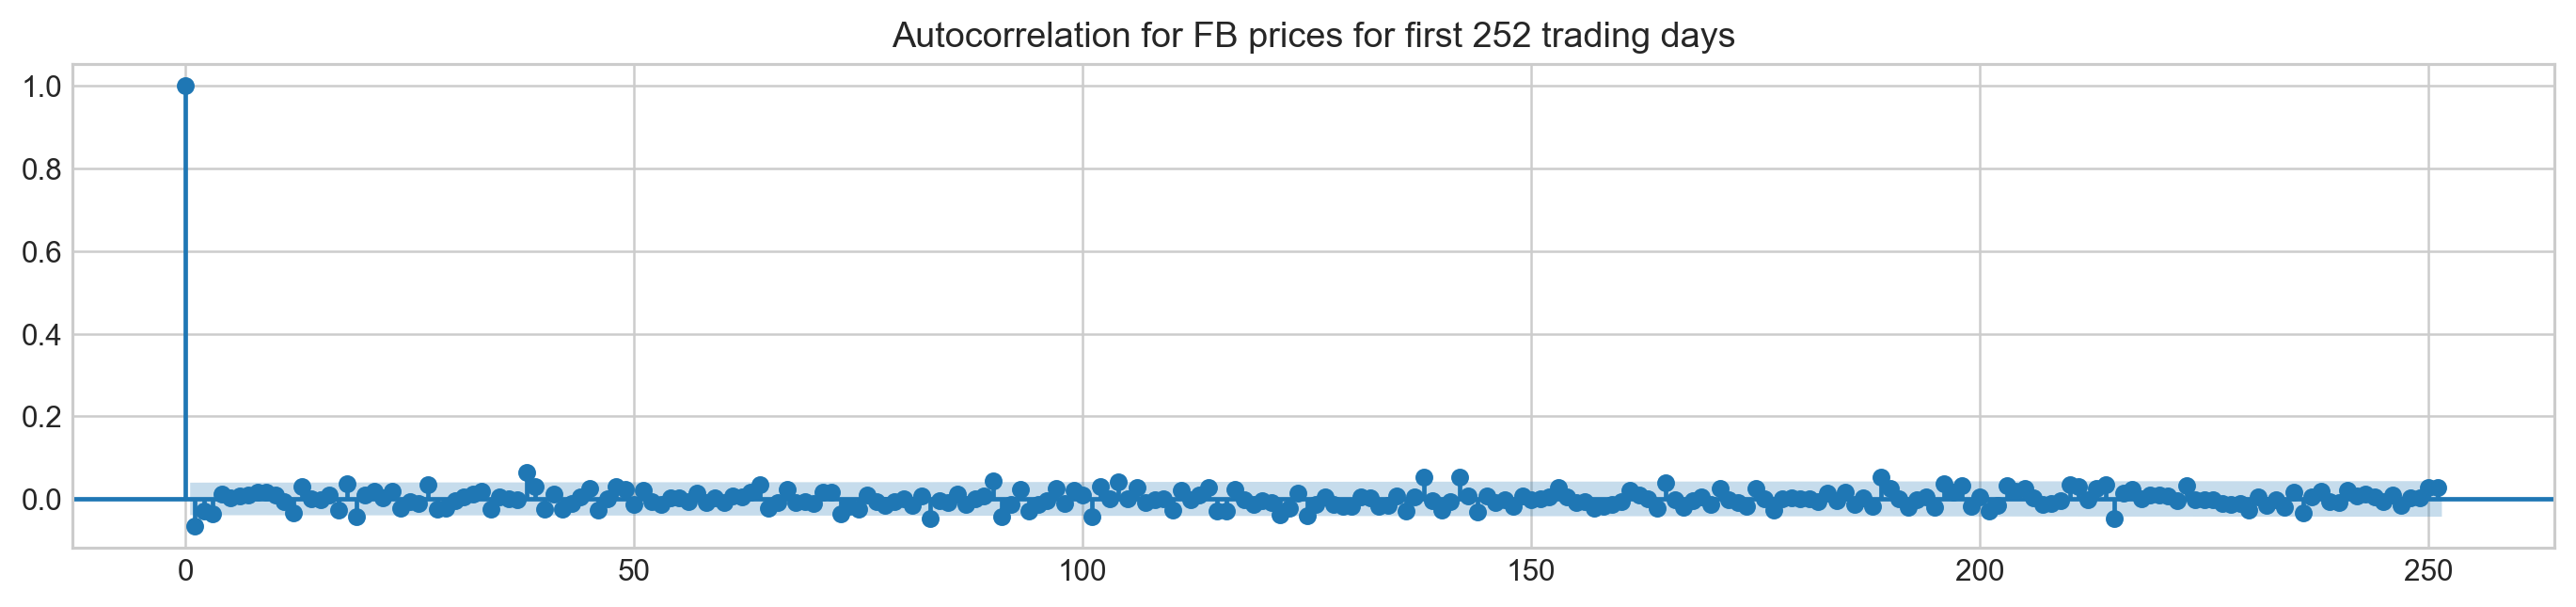

In [14]:
plt.rcParams['figure.figsize'] = (15,3)
plot_acf(stocks[ticker.lower()].Return, lags=range(252))
plt.title(f'Autocorrelation for {ticker.upper()} prices for first 252 trading days')
plt.show()

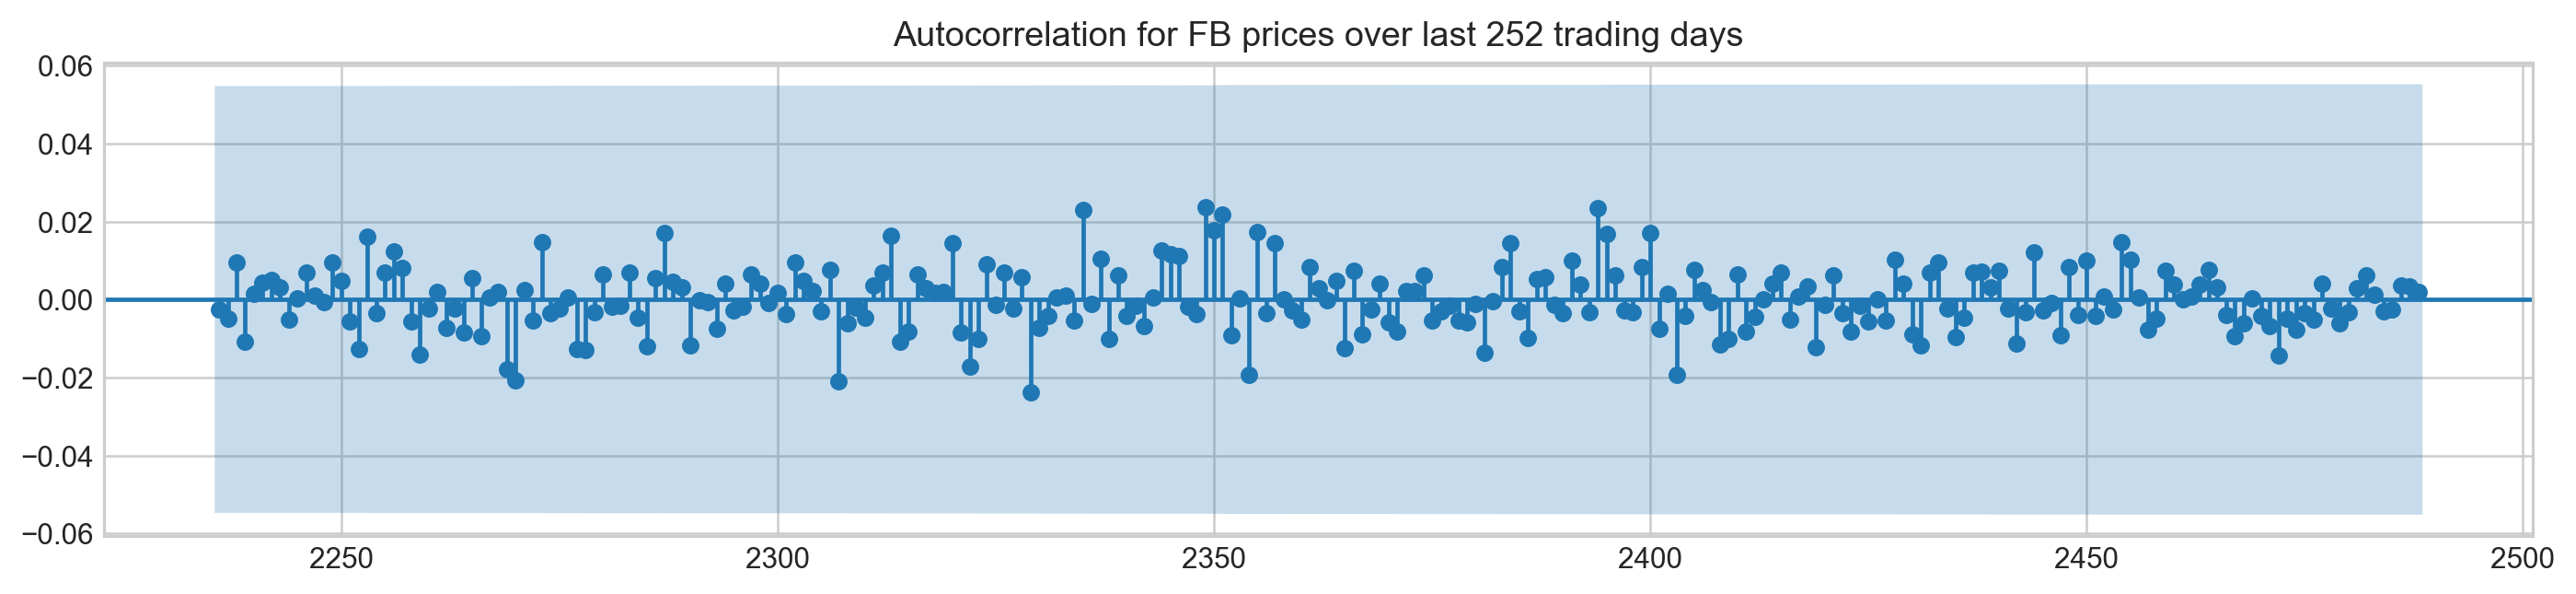

In [15]:
plt.rcParams['figure.figsize'] = (15,3)
plot_acf(stocks[ticker.lower()].Return, lags=range(last_252,all_entries))
plt.title(f'Autocorrelation for {ticker.upper()} prices over last 252 trading days')
plt.show()

#### Make Time Series 'Stationary' by Differencing 
- Differencing: subtract previous value from current value 

In [16]:
# ARIMA Orders
# (p,d,q) -> (lag order, degree of differencing, order of moving average)
orders = [(0,0,0), 
          (1,0,0),
          (0,1,0),
          (0,0,1),
          (1,1,0)]

Binary = lambda data: [1 if x > 0 else 0 for x in data]

In [17]:
all_predictions = {}
accuracy_list = {}

for order in orders:
    try: 
        # shallow copy: new collection object and populating with references to child objects found in the original 
        # a reference of an object is copied in the other object
        # changes do a copy DO REFLECT in the other object 
        history = train.copy() 
        order_predictions = []
    
        for i in range(len(test)):
            model = ARIMA(history, order=order) #(observed time series, order=(p,d,q))
            model_fit = model.fit(disp=0) #trains model using input training and data -> (disp=0) hides data
            y_hat = model_fit.forecast() #predicited value of y (dependent variable) in regression equation  
            order_predictions.append(y_hat[0][0]) #first element the prediction 
            history.append(test[i]) #adding following day's 'return' value to the model 
            print(f"{ticker.upper()} prediction: {i+1} of {len(test)}", end='\r')
    
        # Binary = lambda data: [1 if x > 0 else 0 for x in data]
        accuracy = accuracy_score(Binary(test),
                                   Binary(order_predictions))
        accuracy_list[order] = round(accuracy,3)*100
        print('                       ', end='\r')
        print(f"{order} - {round(accuracy,3)*100}% accuracy", end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(f"{order} <== Wrong Order", end='\r')
        pass  

/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 0) - 49.5% accuracy
(1, 0, 0) - 52.800000000000004% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0) - 45.800000000000004% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 1) - 52.5% accuracy


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/CODEUSR/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0) - 44.2% accuracy


#### Review Predictions on Data

In [18]:
print(accuracy_list)
# print(all_predictions)
best_accuracy = max(accuracy_list.values())
best_order = max(accuracy_list, key=accuracy_list.get)
print(best_accuracy)
print(best_order)

{(0, 0, 0): 49.5, (1, 0, 0): 52.800000000000004, (0, 1, 0): 45.800000000000004, (0, 0, 1): 52.5, (1, 1, 0): 44.2}
52.800000000000004
(1, 0, 0)


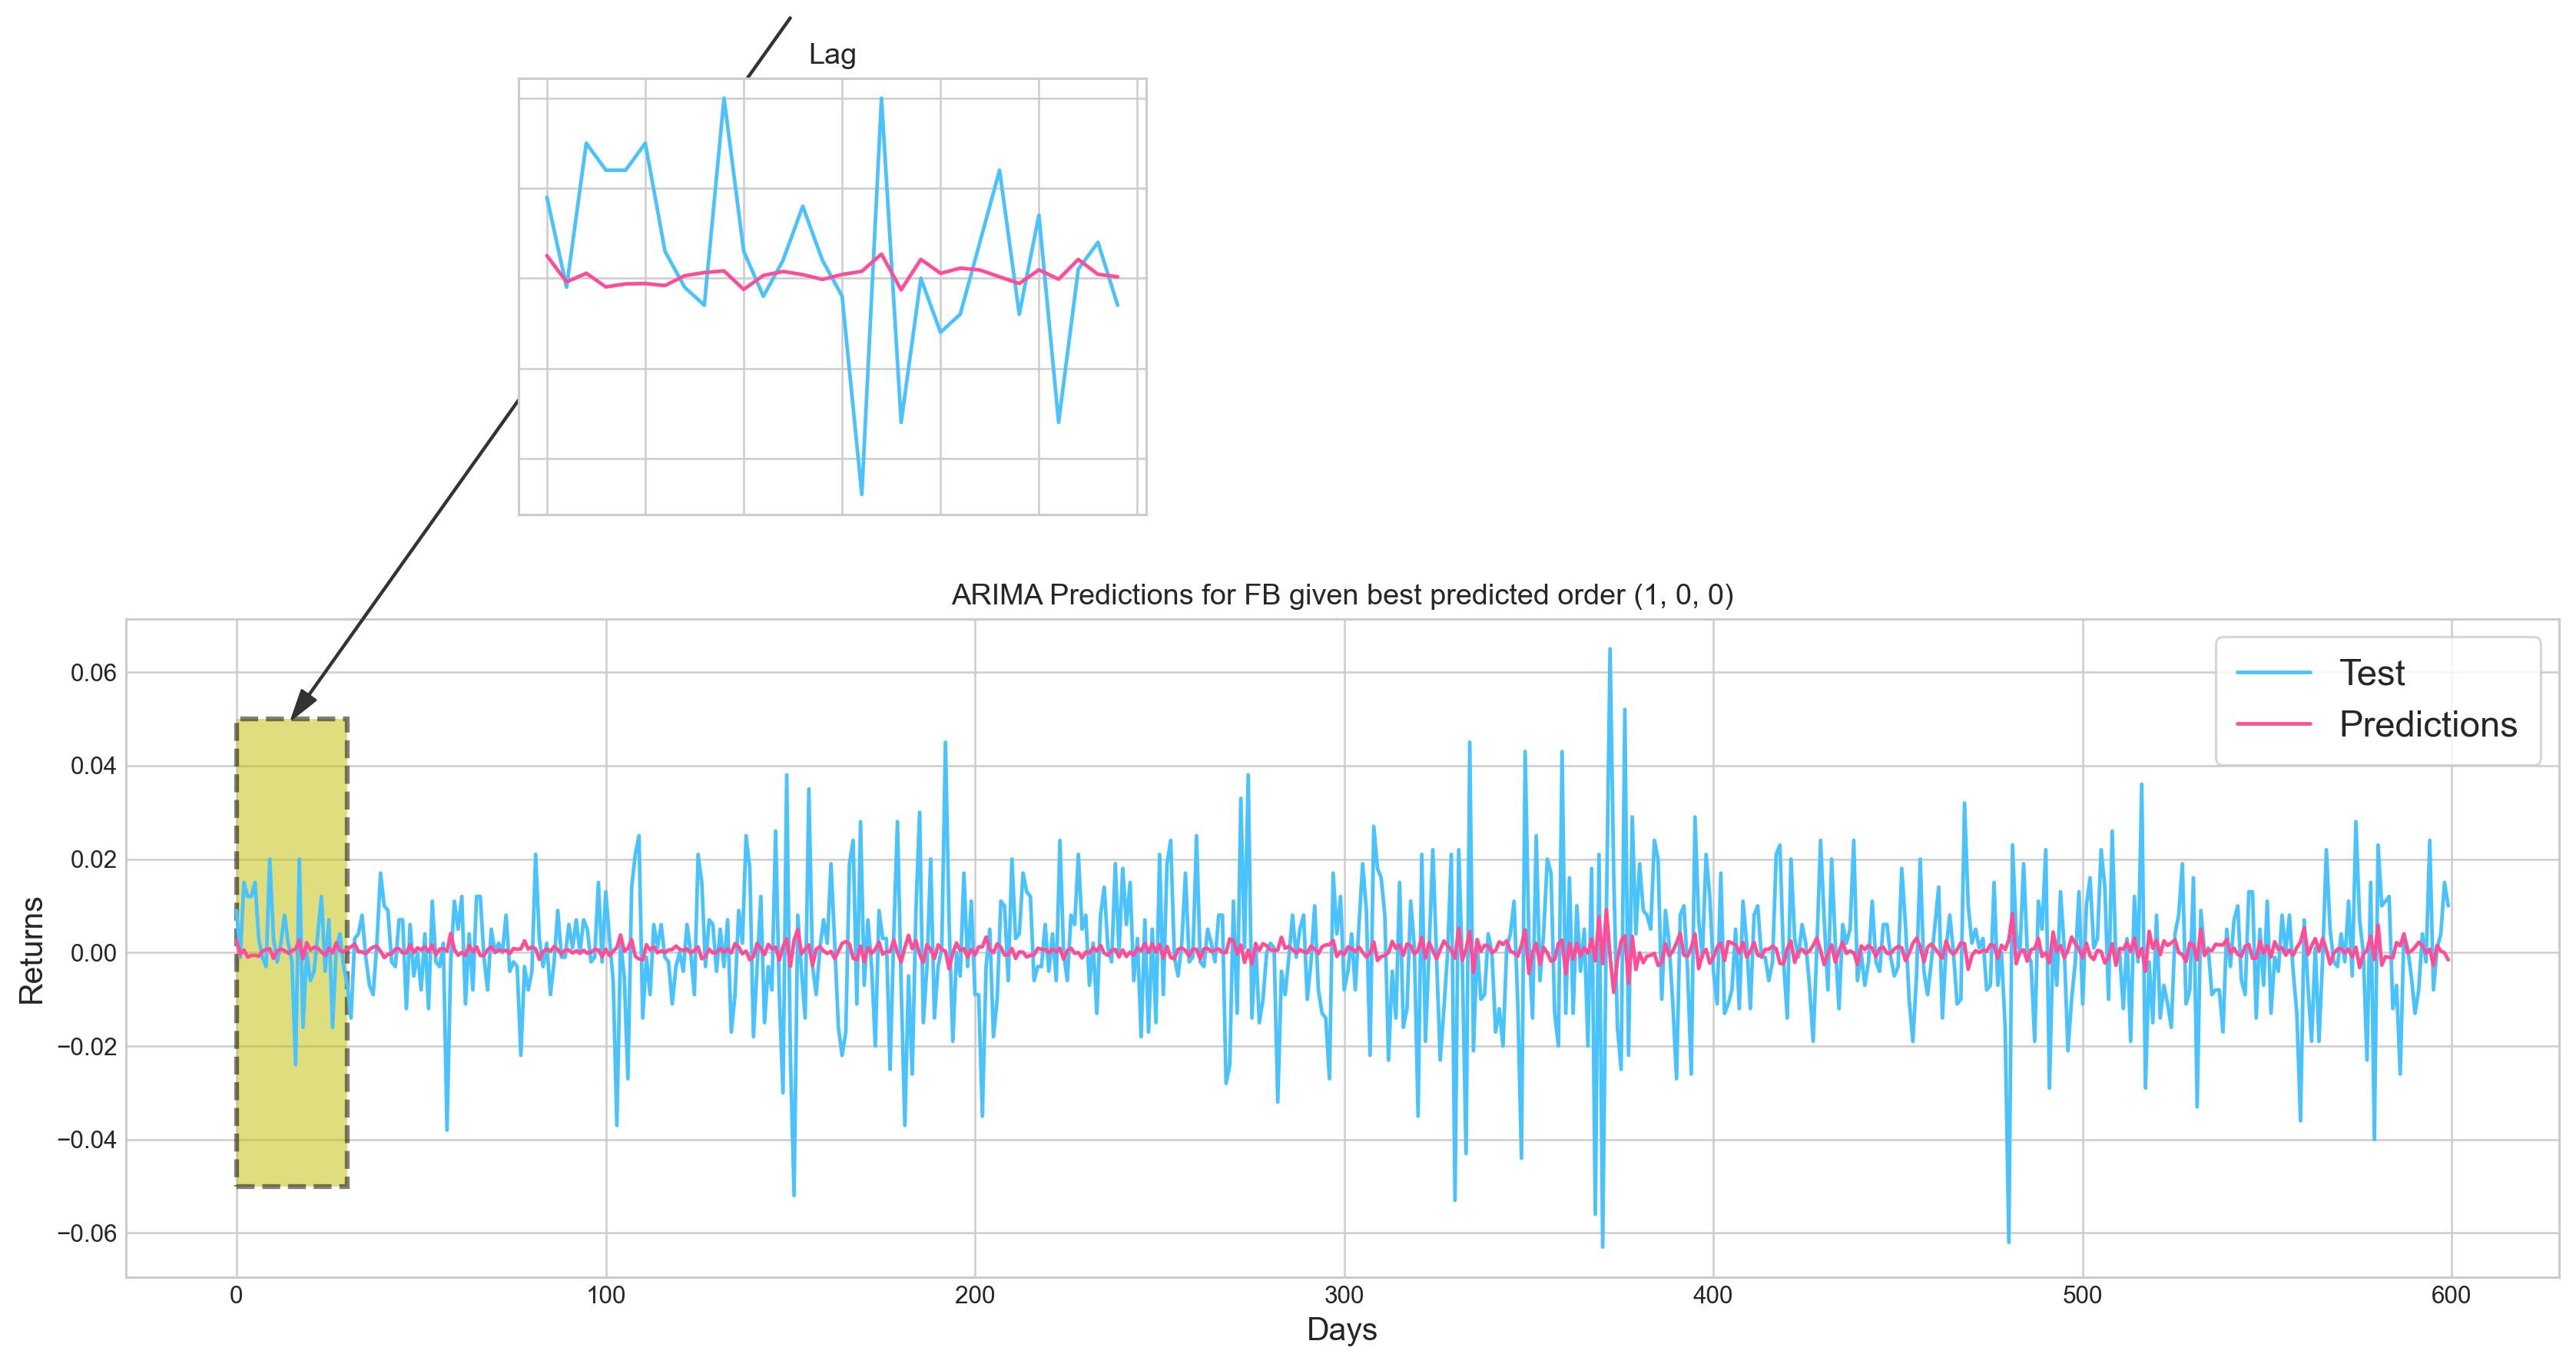

In [19]:
# Main Plot
fig = plt.figure(figsize=(18,5))
plt.plot(test, label='Test', color=lightblue)
plt.plot(all_predictions[best_order], label='Predictions', color=pinkyred)

plt.legend(frameon=True, loc=1, ncol=1, fontsize=15, borderpad=.6)
plt.title(f"ARIMA Predictions for {ticker.upper()} given best predicted order {best_order}")
plt.xlabel('Days',fontsize=13)
plt.ylabel('Returns',fontsize=13)

# Arrow from Subplot to Main Plot
plt.annotate('',
            xy=(15,0.05),
            xytext=(150,.2),
            fontsize=10,
            arrowprops={'width':0.4, 'headwidth':7,'color':black})

# Small Subplot
ax = fig.add_subplot(1,1,1)
rect = patches.Rectangle((0,-.05),30,.1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

plt.axes([.25,1,.2,.5])
plt.plot(test[:30], color=lightblue)
plt.plot(all_predictions[best_order][:30], color=pinkyred)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')


plt.show();

#### Histogram 

In [20]:
num_bins = 20

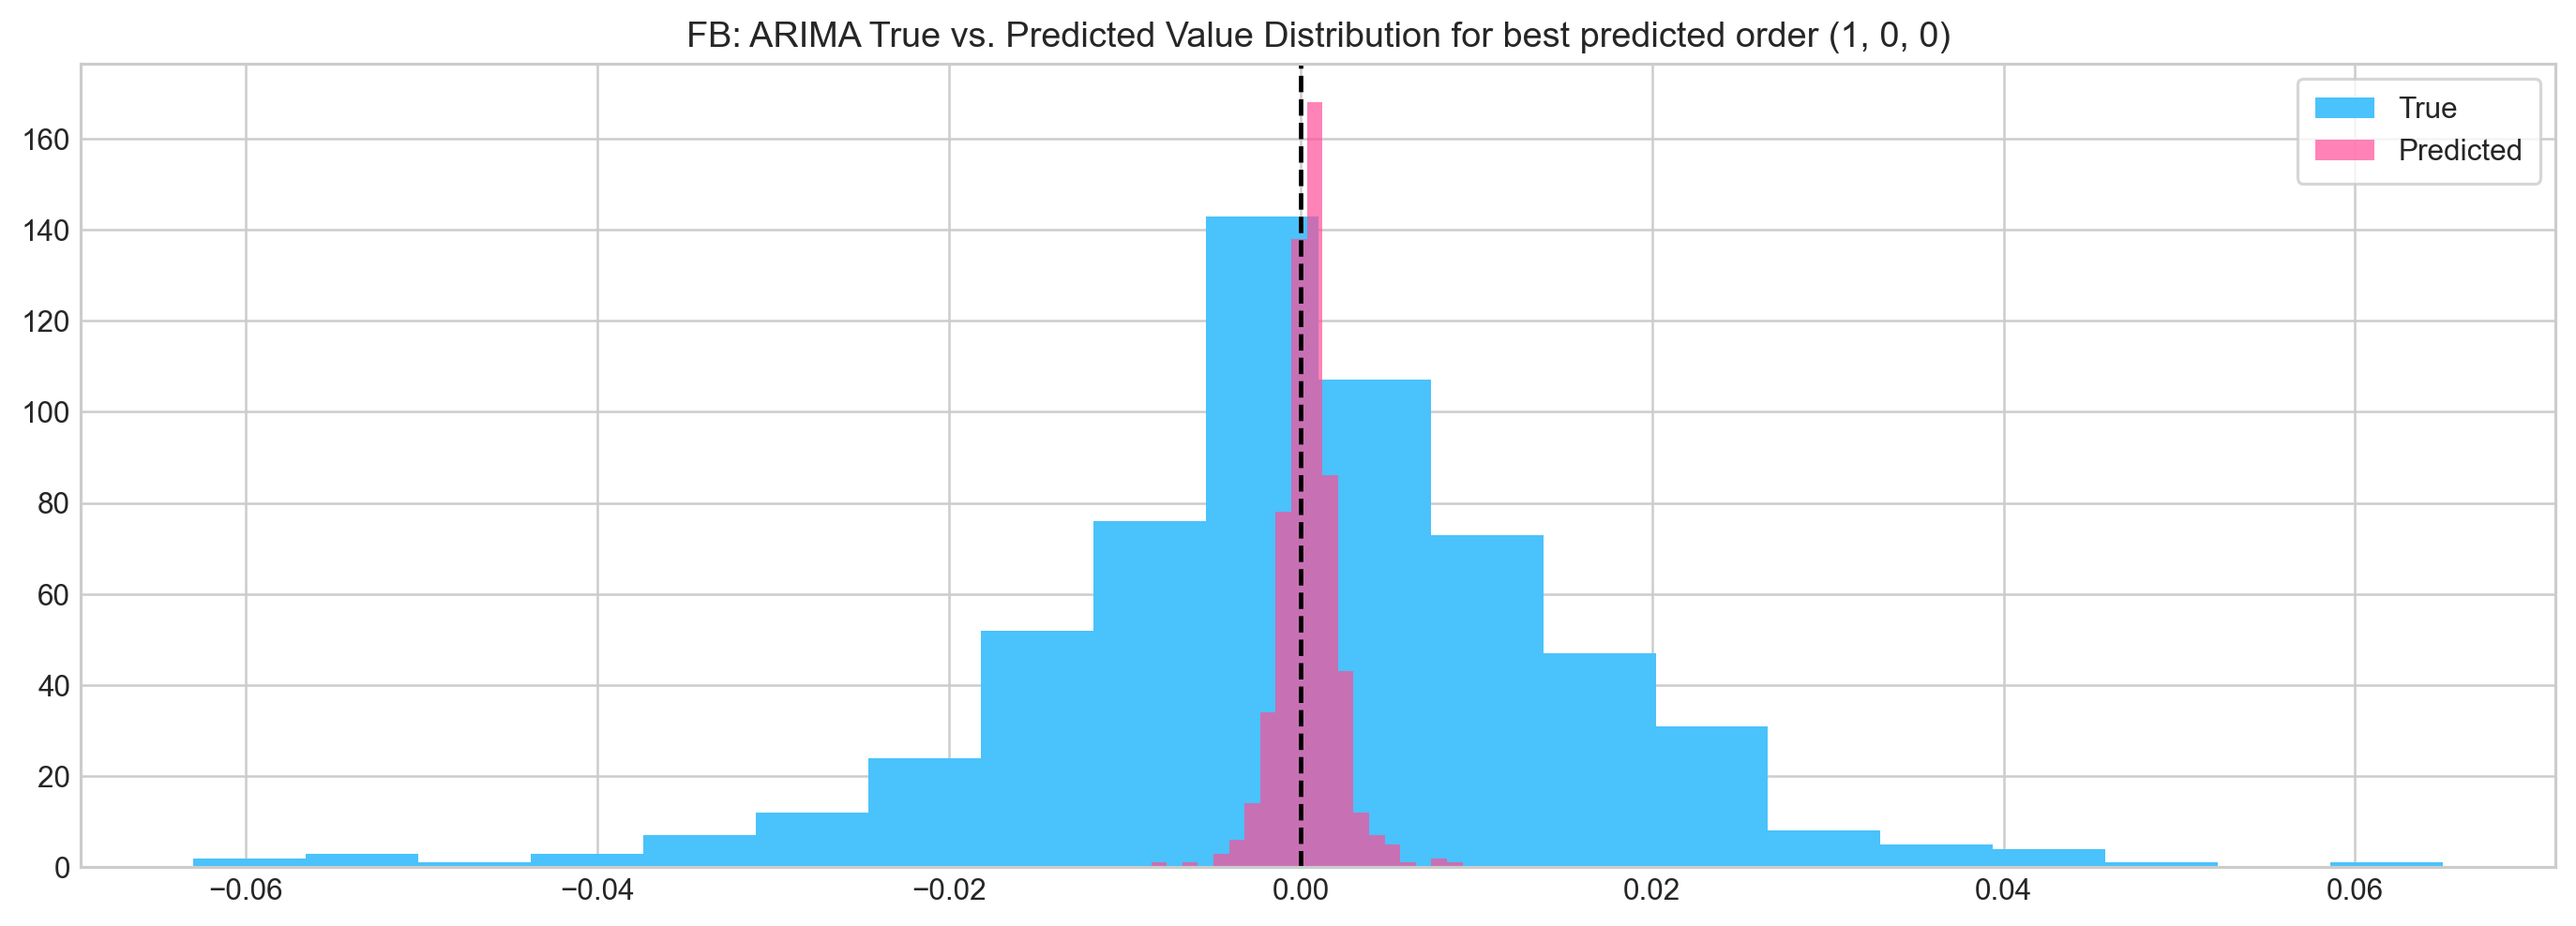

In [21]:
plt.figure(figsize=(15,5))
plt.hist(stocks[ticker.lower()][test_600:last_600].reset_index().Return, 
         bins=num_bins, label='True', facecolor=lightblue)
plt.hist(all_predictions[best_order], 
         bins=num_bins, label='Predicted', color=pinkyred, alpha=.7)
plt.axvline(0,c='k',ls='--')

plt.title(f"{ticker.upper()}: ARIMA True vs. Predicted Value Distribution for best predicted order {best_order}")
plt.legend(frameon=True,loc=1, ncol=1,fontsize=10,borderpad=.6)
plt.show()

#### Interpret via Confusion Matrix

In [22]:
Binary = lambda data: [1 if x > 0 else 0 for x in data]

test_binary = Binary(stocks[ticker.lower()][test_600:last_600].reset_index().Return)
train_binary = Binary(all_predictions[best_order])

tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print(f"True Positive and Negative: {tp + tn}")
print(f"False Positive and Negative: {fp + fn}")
print(f"Accuracy: {round(accuracy*100, 5)}%")

True Positive and Negative: 317
False Positive and Negative: 283
Accuracy: 52.83333%


---
# Features Selection via [XGBoost](measurementsUsed/xgboost.md)
- extract features for neural networks to improve model accuracy and boost training 
---

In [23]:
def scale(dataframe, scale=(0,1)):
    # Scale Features to [0-1]
    columns = dataframe.columns 
    scaler = MinMaxScaler()
    scaler.feature_range = scale 
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=columns)

In [24]:
scaled_ticker = scale(stocks[ticker.lower()], scale=(0,1))
# print(scaled_ticker)

In [25]:
X = scaled_ticker[:-1]
y = stocks[ticker.lower()].Return.shift(-1)[:-1]
# print(Y)

In [26]:
xgb = XGBClassifier()
xgb.fit(X[1500:],y[1500:], eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [27]:
important_features = pd.DataFrame({ 'Feature': X.columns,
                                  'Importance': xgb.feature_importances_}) \
                                .sort_values('Importance', ascending=True)

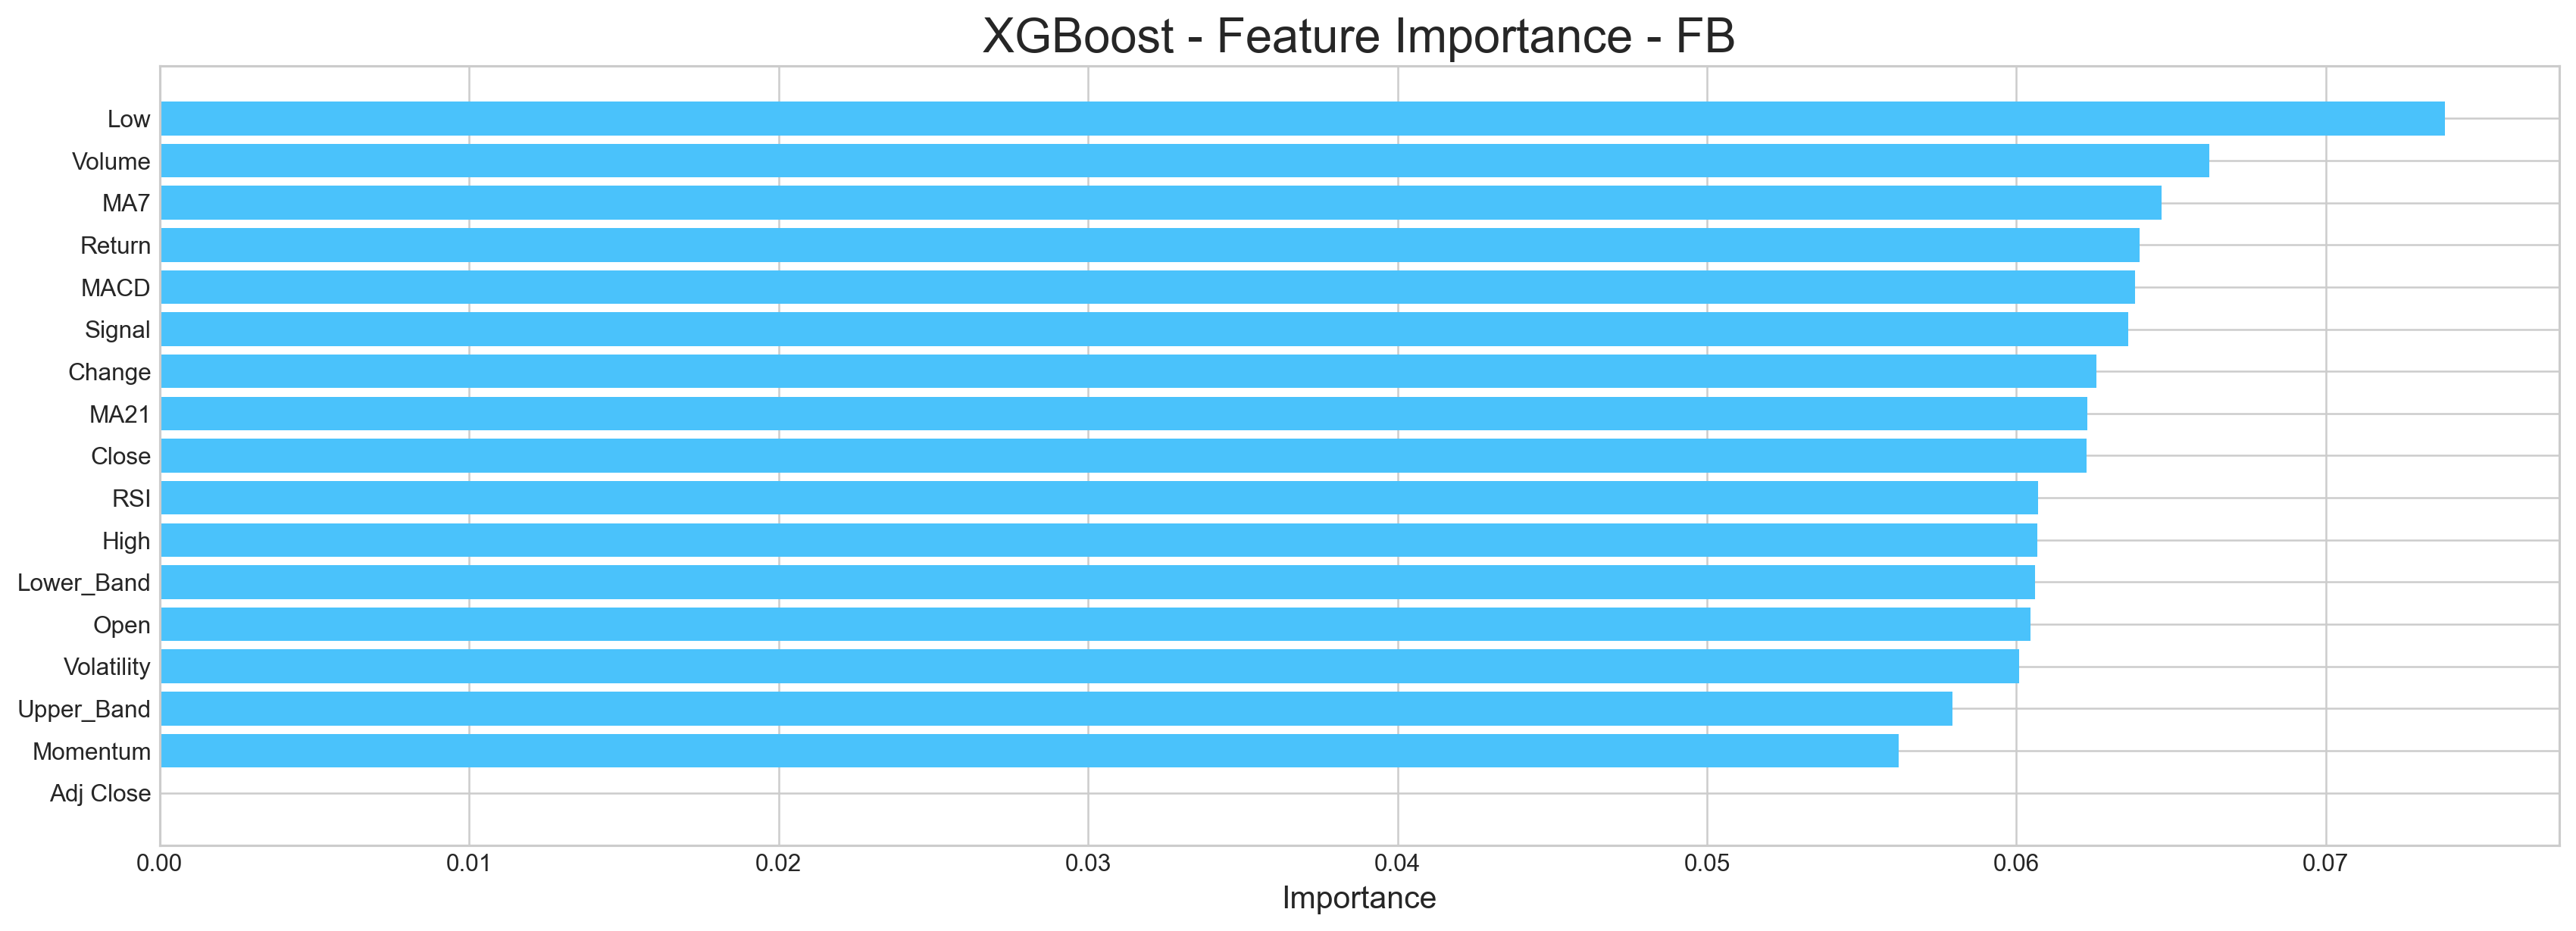

In [28]:
plt.figure(figsize=(18,6))
plt.style.use('seaborn-whitegrid')
plt.barh(important_features.Feature, important_features.Importance, color=lightblue)

plt.title(f"XGBoost - Feature Importance - {ticker.upper()}", fontsize=20)
plt.xlabel('Importance', fontsize=13)
plt.show()

---
# Deep Neural Networks
---
#### Import Libraries

In [29]:
import tensorflow.keras as keras

from tensorflow.python.keras.optimizer_v2 import rmsprop
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model

# Tensorflow Keras Libraries Used
# LSTM Network 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential 




from bayes_opt import BayesianOptimization
from functools import partial 

#### Prepare Data

In [30]:
n_steps = 21

scaled_ticker = scale(stocks[ticker.lower()], scale=(0,1))
# print(scaled_ticker)
scaled_ticker.isna().sum()

High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
Return         0
Change         0
Volatility     1
MA7            6
MA21          20
Momentum       3
RSI           14
MACD           0
Signal         0
Upper_Band    20
Lower_Band    20
dtype: int64

In [31]:
scaled_ticker.dropna(inplace=True)

In [32]:
print('No Missing Data') if sum(scaled_ticker.isna().sum())==0 else scaled_ticker.isna().sum()

No Missing Data


In [33]:
def split_multivariate(features, target, n_steps, split=True, ratio=0.8):
    
    X, y = [], []
    for i in range(len(features)):
        end_index = i + n_steps
        if end_index > len(features):
            break
        seq_x, seq_y = features[i:end_index], target[end_index-1]
        X.append(seq_x)
        y.append(seq_y)
        
    if split == True:
        X_train = np.array(X[:round(len(X)*ratio)])
        y_train = np.array(y[:round(len(X)*ratio)])
        X_test = np.array(X[round(len(X)*ratio):])
        y_test = np.array(y[round(len(X)*ratio):])
        
        return X_train, y_train, X_test, y_test
    else:
        return np.array(X), np.array(y)

In [34]:
X_train, \
y_train, \
X_test, \
y_test = split_multivariate(scaled_ticker.to_numpy()[:-1],
                         stocks[ticker.lower()].Return.shift(-1).to_numpy()[:-1],
                         n_steps,
                         split=True,
                         ratio=0.8)

In [35]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1958, 21, 17)
y_train shape: (1958,)
X_test shape: (490, 21, 17)
y_test shape: (490,)


# LSTM Network

In [36]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

print(f"Steps: {n_steps}")
print(f"Features: {n_features}")

Steps: 21
Features: 17


In [37]:
model = Sequential(name="LSTM_Network_Sequential_Model")

# can pass `Input()` to predefine the shape of the model in it's own line
# model.add(Input(shape=(n_steps,n_features)))
# model.add(LSTM(100, activation='relu', return_sequences=True))

# or you can pass it into the first layer 
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [38]:
# Layer Weight and Biases 
num_layers = len(model.layers)

layers_weights = {}
layers_biases = {}
for i in range(num_layers):
    layers_weights[i] = model.layers[i].get_weights()[0]
    layers_biases[i] = model.layers[i].get_weights()[1]

print(f"Layers of the Sequential Model: {num_layers}")
print(f" Bias defined when layer is called to be added to model")
print(f" Layer 1: (Weight: {len(layers_weights[0])}, Bias: {len(layers_biases[0])})")
print(f" Layer 2: (Weight: {len(layers_weights[1])}, Bias: {len(layers_biases[1])})")
print(f" Layer 3: (Weight: {len(layers_weights[2])}, Bias: {len(layers_biases[2])})")
print(f" Layer 4: (Weight: {len(layers_weights[3])}, Bias: {len(layers_biases[3])})")

Layers of the Sequential Model: 4
 Bias defined when layer is called to be added to model
 Layer 1: (Weight: 17, Bias: 100)
 Layer 2: (Weight: 100, Bias: 50)
 Layer 3: (Weight: 50, Bias: 10)
 Layer 4: (Weight: 10, Bias: 1)


In [39]:
print(model.summary())

Model: "LSTM_Network_Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 100)           47200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 77,921
Trainable params: 77,921
Non-trainable params: 0
_________________________________________________________________
None


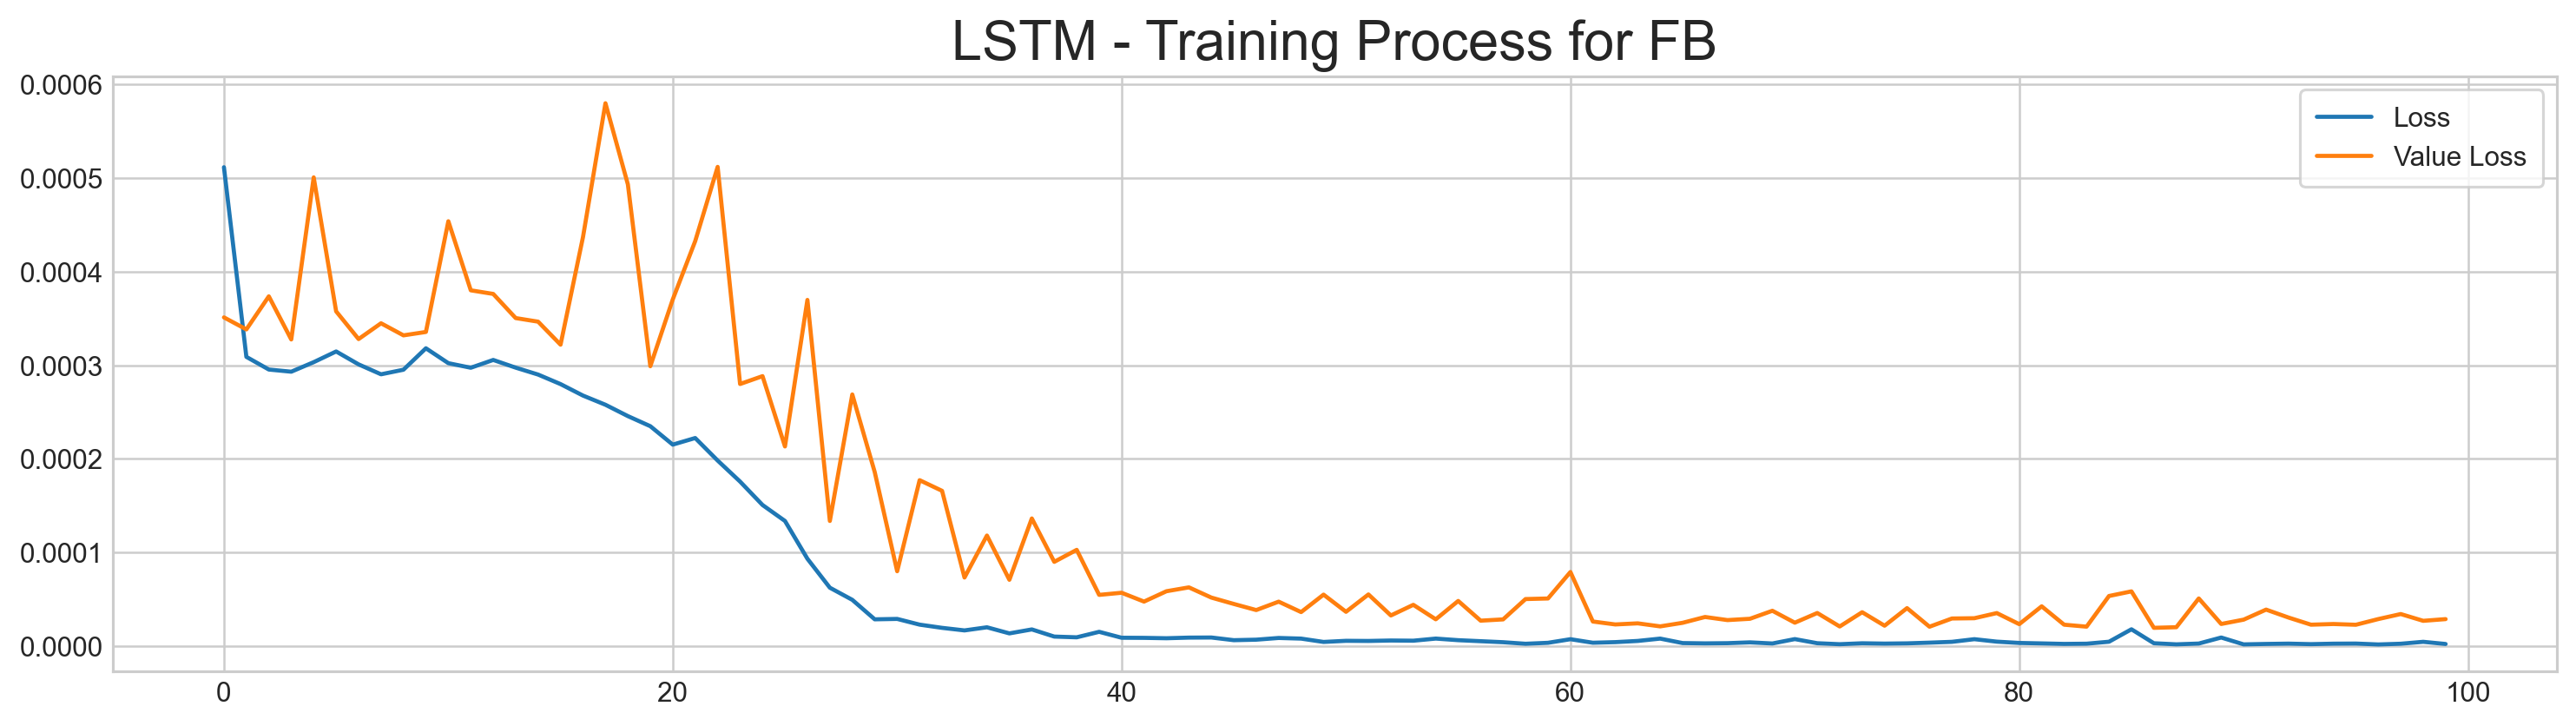

In [40]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1, borderpad=.6)
plt.title(f"LSTM - Training Process for {ticker.upper()}", fontsize=20)
plt.show()

##### LSTM Network: Daily Return Prediction 

In [ ]:
def MLevaluation(X, y, model, n_preds=10, random=True, show_graph=True): 
    
    n_steps = X.shape[1]
    max_random_int = len(y) - n_steps 
    y_true, y_pred = [], []
    prediction_accuracy, slices = [],[]
    
    for i in range(n_preds): 
        if random == True: 
            position = np.random.randint(0, max_random_int)
        else: 
            position = i 
        
        y_hat = model.predict(X[position:position+1])[0][0]
        y_pred.append(y_hat)
        y_true.append(y[position])
        y_current = y[position]
        
        
        
        # if correctly predics return c=0
        # else: c= previous sequence position 
        if y.min() < 0: c = 0 
        else: c = y[position-1]
            
        if ((y_hat > c) & (y_current > c)) or ((y_hat < c) & (y_current < c)): 
                acc = 1
        else: 
            acc = 0 
              
            
        prediction_accuracy.append(acc)
        slices.append((list(y[position - n_steps:position + 1]), 
                      list(y[position - n_steps: position]) + [y_hat], 
                      acc))
        
        
    if show_graph == True: 
        plt.rcParams['figure.dpi'] = 227
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(18,5))
        
        plt.bar(range(n_preds), y_true[:], width=.7, alpha=.6, color=lightblue, label="True")
        plt.bar(range(n_preds), y_pred[:], width=.7, alpha=.6, color=pinkyred, label="Predicted")
        plt.axhline(0, color=black, lw=.8)
        
        plt.legend(loc=1)
        plt.title(f"Daily Return Prediction for {ticker.upper()}", fontsize=15)
        plt.show()
    
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Accuracy: {round((sum(prediction_accuracy)/len(prediction_accuracy) * 100),2)}%")
    return slices, np.array(y_true), np.array(y_pred)
        

In [ ]:
# one of these inputs is 'NAN'
# no predicted 
pred, y_true, y_pred = MLevaluation(X_test, y_test, model, random=False, n_preds=50, show_graph=True)

# Convolutional Network

In [ ]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential() 

model.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1)
plt.title('Convolutional Network: Training Process for '+ticker.upper())
plt.show()

In [50]:
def evaluation(X, y, model, n_preds=10, random=True, show_graph=True):
    
    n_steps = X.shape[1]
    max_random_int = len(y) - n_steps
    
    y_true, y_pred = [], []
    pred_accuracy, slices = [], []
    
    for i in range(n_preds):
        if random == True: 
            position = np.random.randint(0, max_random_int)
        else:
            position = i 
            
        y_hat = model.predict(X[position:position+1])[0][0]
        y_pred.append(y_hat)
        y_true.append(y[position])
        y_current = y[position]
        
        if y.min() < 0:
            c = 0 
        else: 
            c = y[position-1]
        
        if ((y_hat > c) & (y_current > c)) or ((y_hat < c) & (y_current < c)): 
            acc = 1
        else:
            acc = 0 
            
        pred_accuracy.append(acc)
        slices.append((list(y[position-n_steps : position+1]) + [y_hat], acc))
    
    if show_graph == True:
        plt.rcParams['figure.dpi']=227
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(18,5))
        
        plt.bar(range(n_preds), y_true[:], width=.7, alpha=.6, color=lightblue, label="True")
        plt.bar(range(n_preds), y_pred[:], width=.7, alpha=.6, color=pinkyred, label="Predicted")
        
        plt.axhline(0,color=black,lw=.8)
        plt.legend(frameon=True, loc=1, borderpad=.6)
        plt.title('Convolution Network: Daily Return Prediction for '+ticker.upper(), fontsize=20)
        plt.show()
    
    print('MSE: ', mean_squared_error(y_true,y_pred))
    print('Accuracy: {}%'.format(round((sum(pred_accuracy)/len(pred_accuracy))*100, 2)))
    return slices, np.array(y_true), np.array(y_pred)

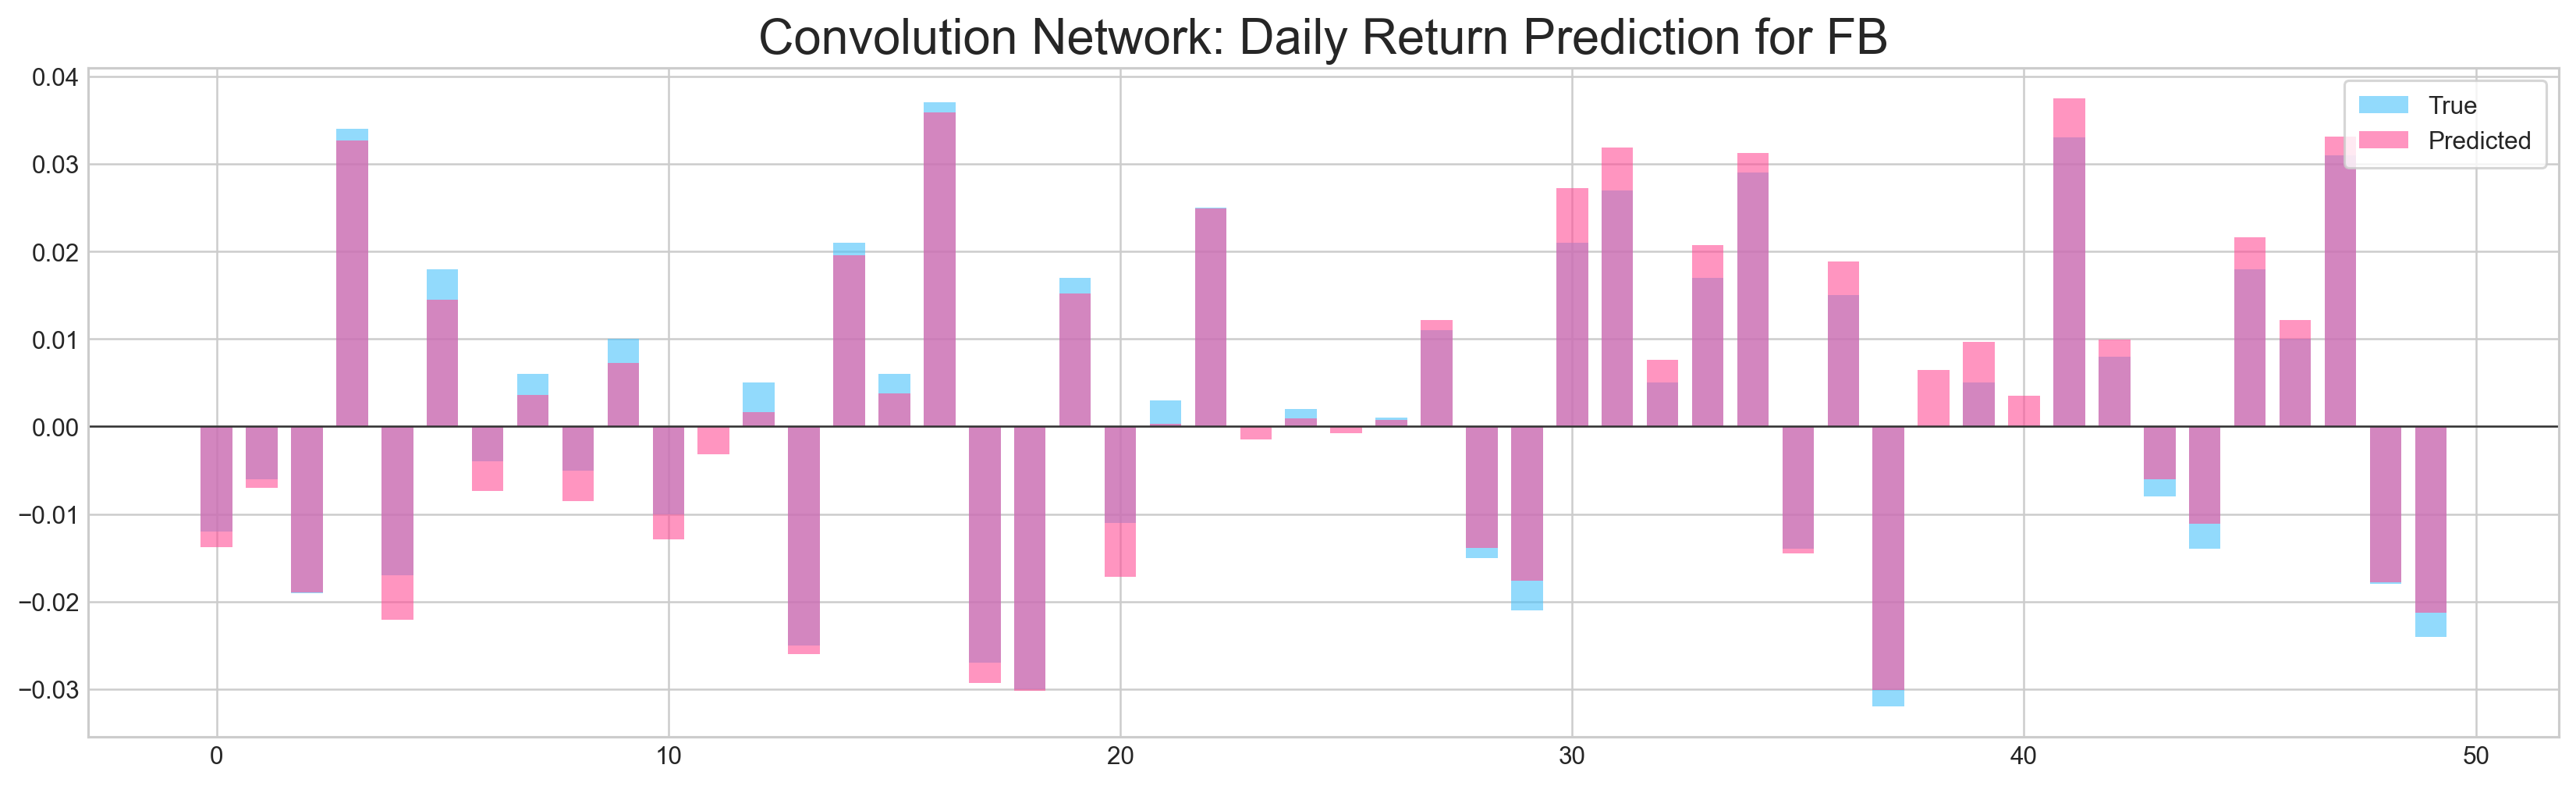

MSE:  8.812175871593521e-06
Accuracy: 90.0%


In [51]:
pred, y_true, y_pred = evaluation(X_test, y_test, model, random=False, n_preds=50, show_graph=True)

## Combined Stock Data

#### Prepare Data

In [52]:
all_stocks = pd.concat(stocks,ignore_index=True)

In [53]:
def scale(dataframe, scale=(0,1)):
    # Scale Features to [0-1]
    columns = dataframe.columns 
    scaler = MinMaxScaler()
    scaler.feature_range = scale 
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=columns)

In [55]:
def split_sequences(features, target, n_steps, split=True, ratio=0.8):
    X, y = [],[]
    
    for i in range(len(features)):
        end_index = i + n_steps
        if end_index > len(features): 
            break
        seq_x, seq_y = features[i:end_index], target[end_index-1]
        X.append(seq_x)
        y.append(seq_y)
    
    if split==True:
        X_train = np.array(X[:round(len(X)*ratio)])
        y_train = np.array(y[:round(len(X)*ratio)])
        X_test = np.array(X[round(len(X)*ratio):])
        y_test = np.array(y[round(len(X)*ratio):])
        return X_train, y_train, X_test, y_test
    else: 
        return np.array(X), np.array(y)

In [56]:
all_scaled = scale(all_stocks, scale=(0,1))

n_steps = 21
X_train, y_train, X_test, y_test = split_sequences(
                                    all_scaled.to_numpy()[:-1], 
                                    all_stocks['Return'].shift(-1).to_numpy()[:-1], n_steps, split=True, ratio=0.8)

### Model Loss
# NAN ISSUE = UPDATE STOCK SELECTION AND CLEAR THE NULL VALUES FROM IT

In [59]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=500, kernel_size=10, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

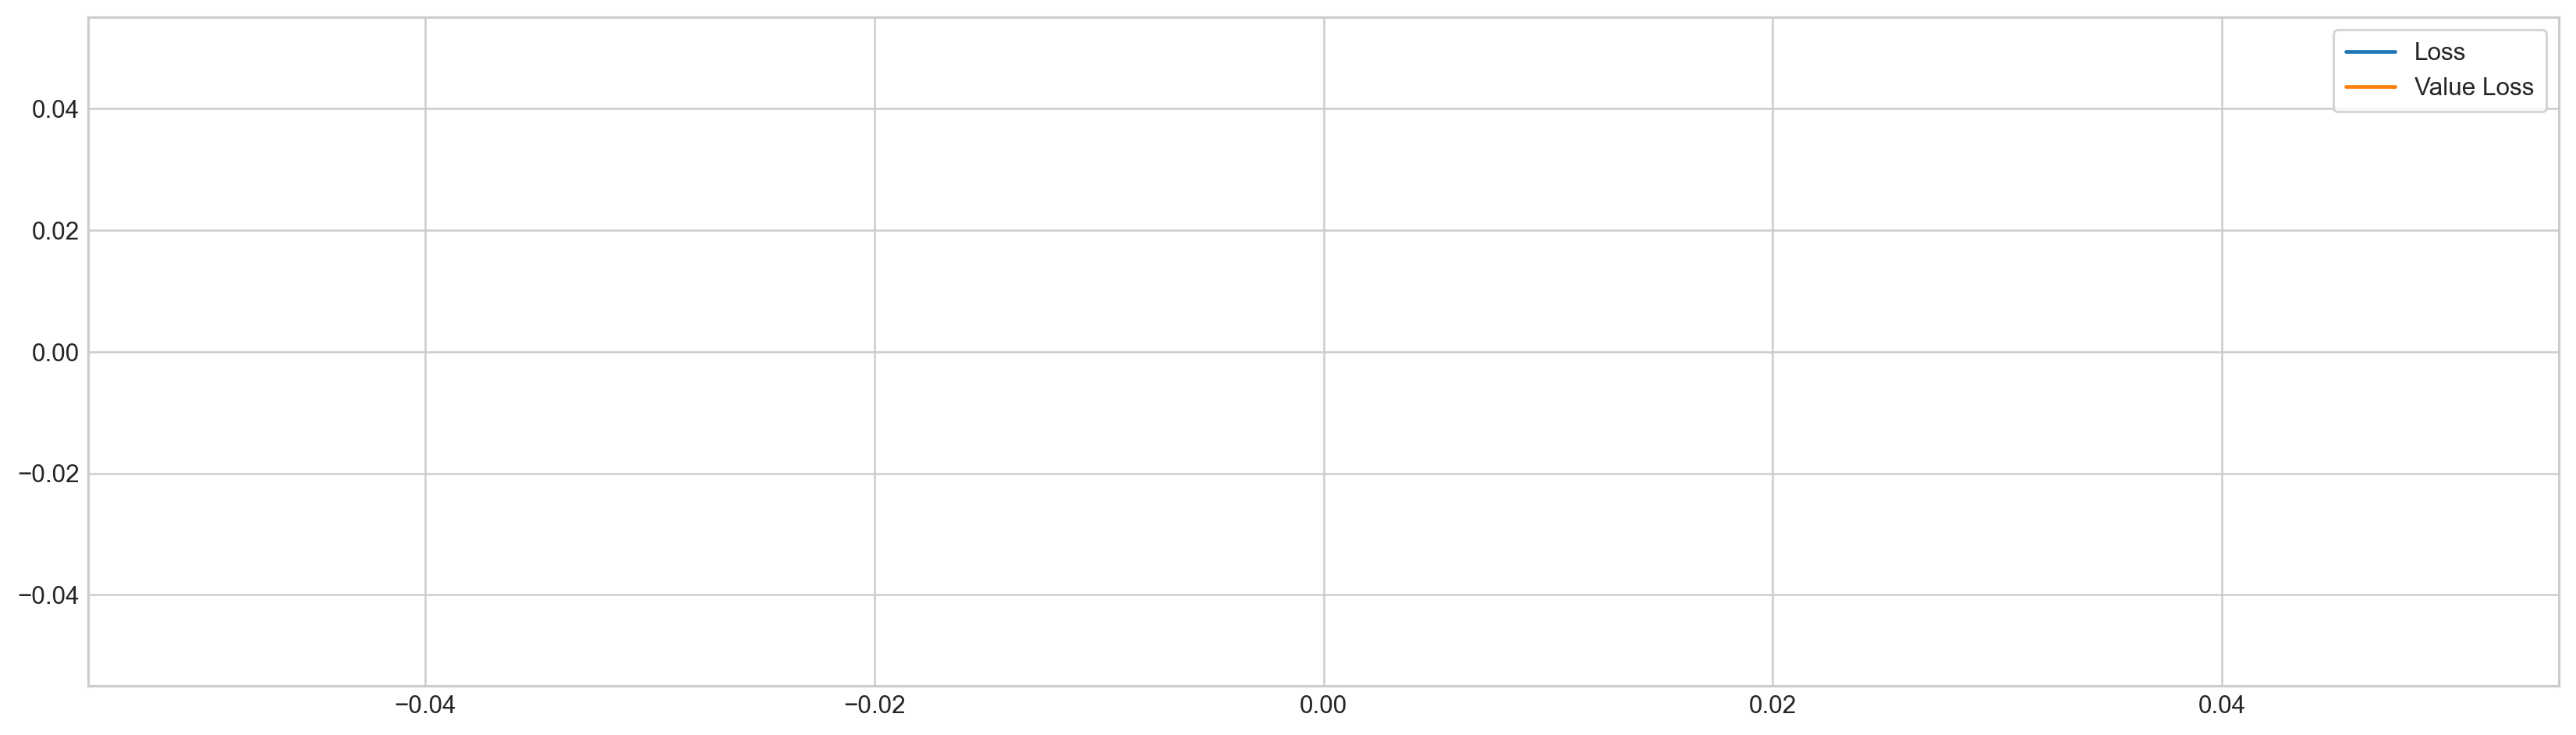

In [60]:
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))

plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Value Loss')

plt.legend(frameon=True, loc=1, borderpad=.5)
plt.show()

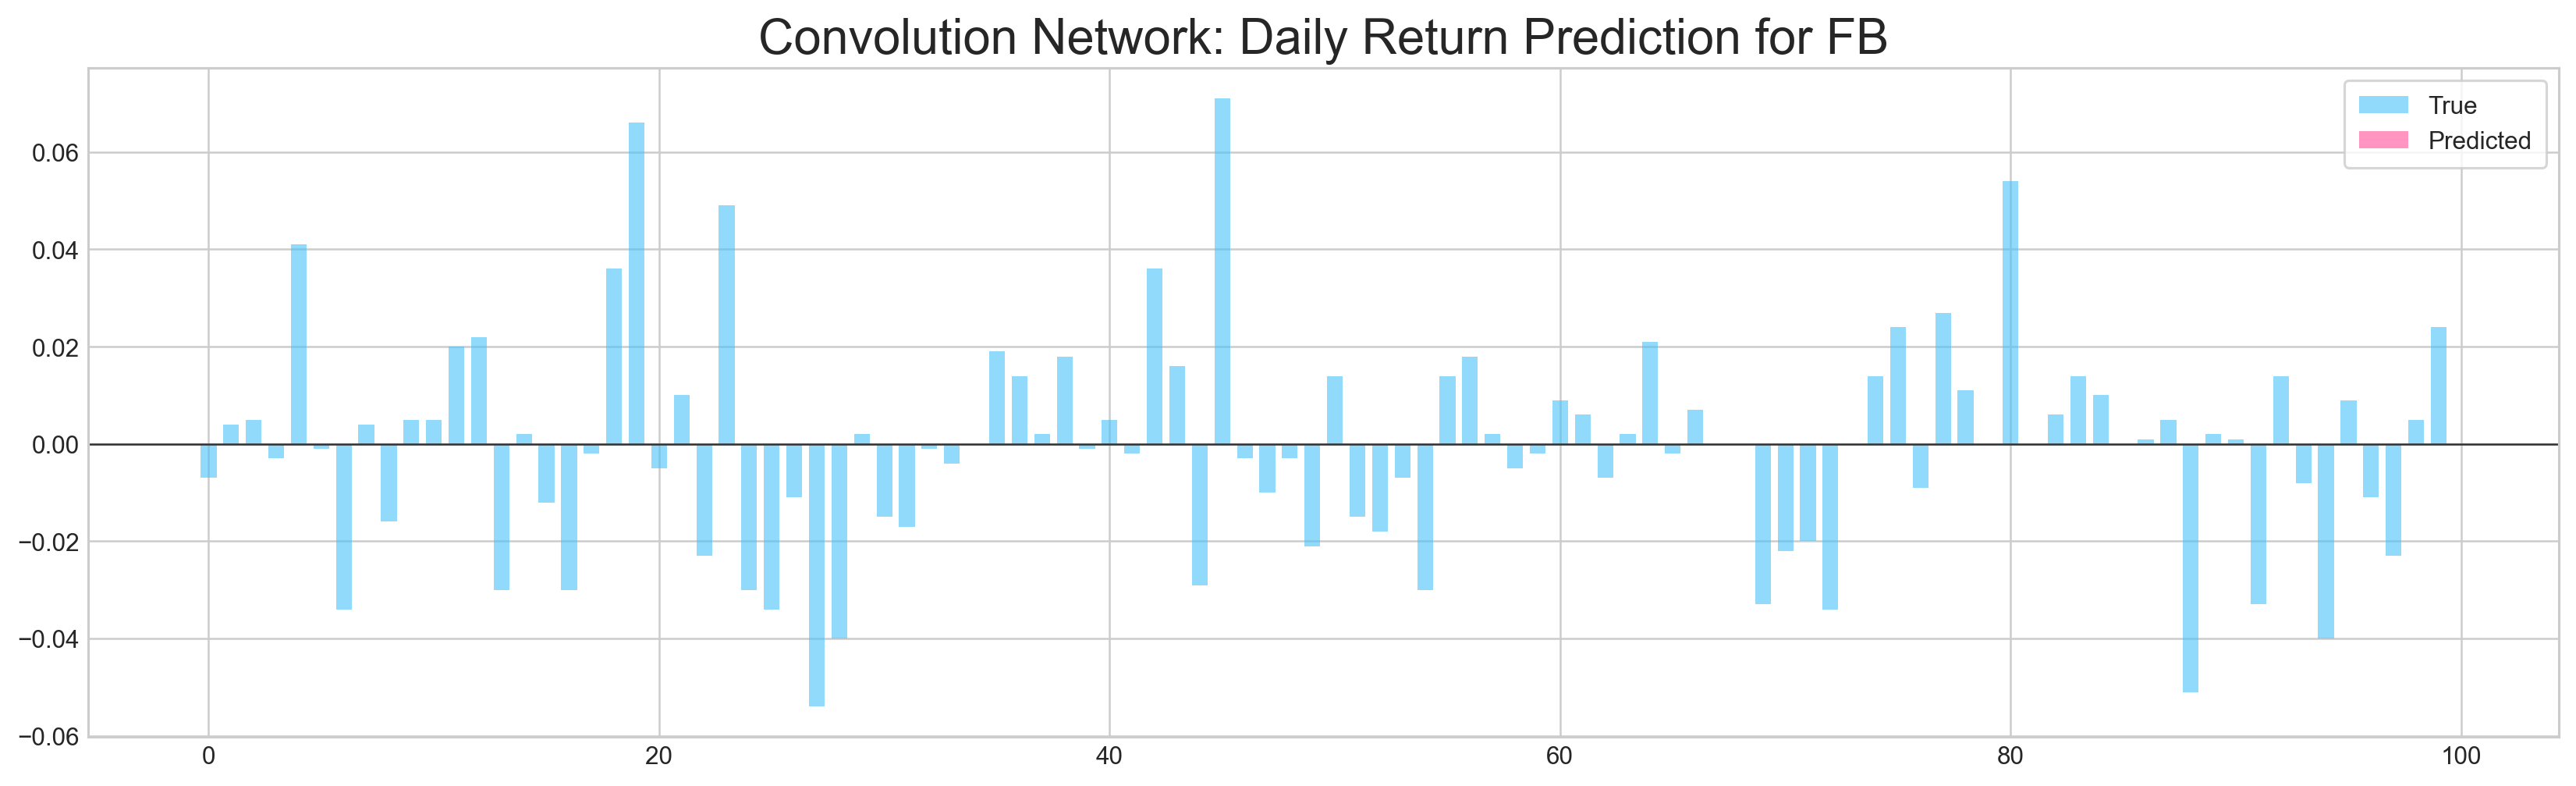

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [61]:
pred, y_true, y_pred = evaluation(
                        X_test, y_test, model, random=True, n_preds=100, show_graph=True)

## Bayesian Optimizaion 

In [66]:
def bayesian_model(d1, d2, filters, pool, kernel):
    keras.backend.clear_session()
    
    d1, d2 = int(d1), int(d2)
    filters, kernel, pool = int(filters), int(kernel), int(pool)
    
    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]
    
    model = Sequential()
    
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(d2, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train, y_train, epochs=4, verbose=0, validation_data=[X_test,y_test], use_multiprocessing=True)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [67]:
def bayesian_optimization():
    
    pbounds = {
        'filters': (1,10),
        'd1': (16,250),
        'd2': (10,40),
        'kernel': (2,10),
        'pool': (2,10)
    }
    optimizer = BayesianOptimization(
                f = bayesian_model, 
                pbounds = pbounds,
                random_state = 1, 
                verbose = 2 
    )
    optimizer.maximize(init_points=5, n_iter=5)
    print(optimizer.max)

In [68]:
n_steps = 21
scaled_ticker = scale(stocks[ticker.lower()], scale = (0,1))

X_train, y_train, X_test, y_test = split_sequences(
            scaled_ticker.to_numpy()[:-1],
            stocks[ticker.lower()].Return.shift(-1).to_numpy()[:-1],
            n_steps,
            split=True,
            ratio=0.8
)            

In [69]:
bayesian_optimization()

|   iter    |  target   |    d1     |    d2     |  filters  |  kernel   |   pool    |
-------------------------------------------------------------------------------------
|  1        |  nan      |  113.6    |  31.61    |  1.001    |  4.419    |  3.174    |
|  2        |  nan      |  37.61    |  15.59    |  4.11     |  5.174    |  6.311    |
|  3        |  nan      |  114.1    |  30.56    |  2.84     |  9.025    |  2.219    |
|  4        |  nan      |  172.9    |  22.52    |  6.028    |  3.123    |  3.585    |
|  5        |  nan      |  203.4    |  39.05    |  3.821    |  7.539    |  9.011    |


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [70]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

keras.backend.clear_session()

model = Sequential()

model.add(Conv1D(filters=9, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=9))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

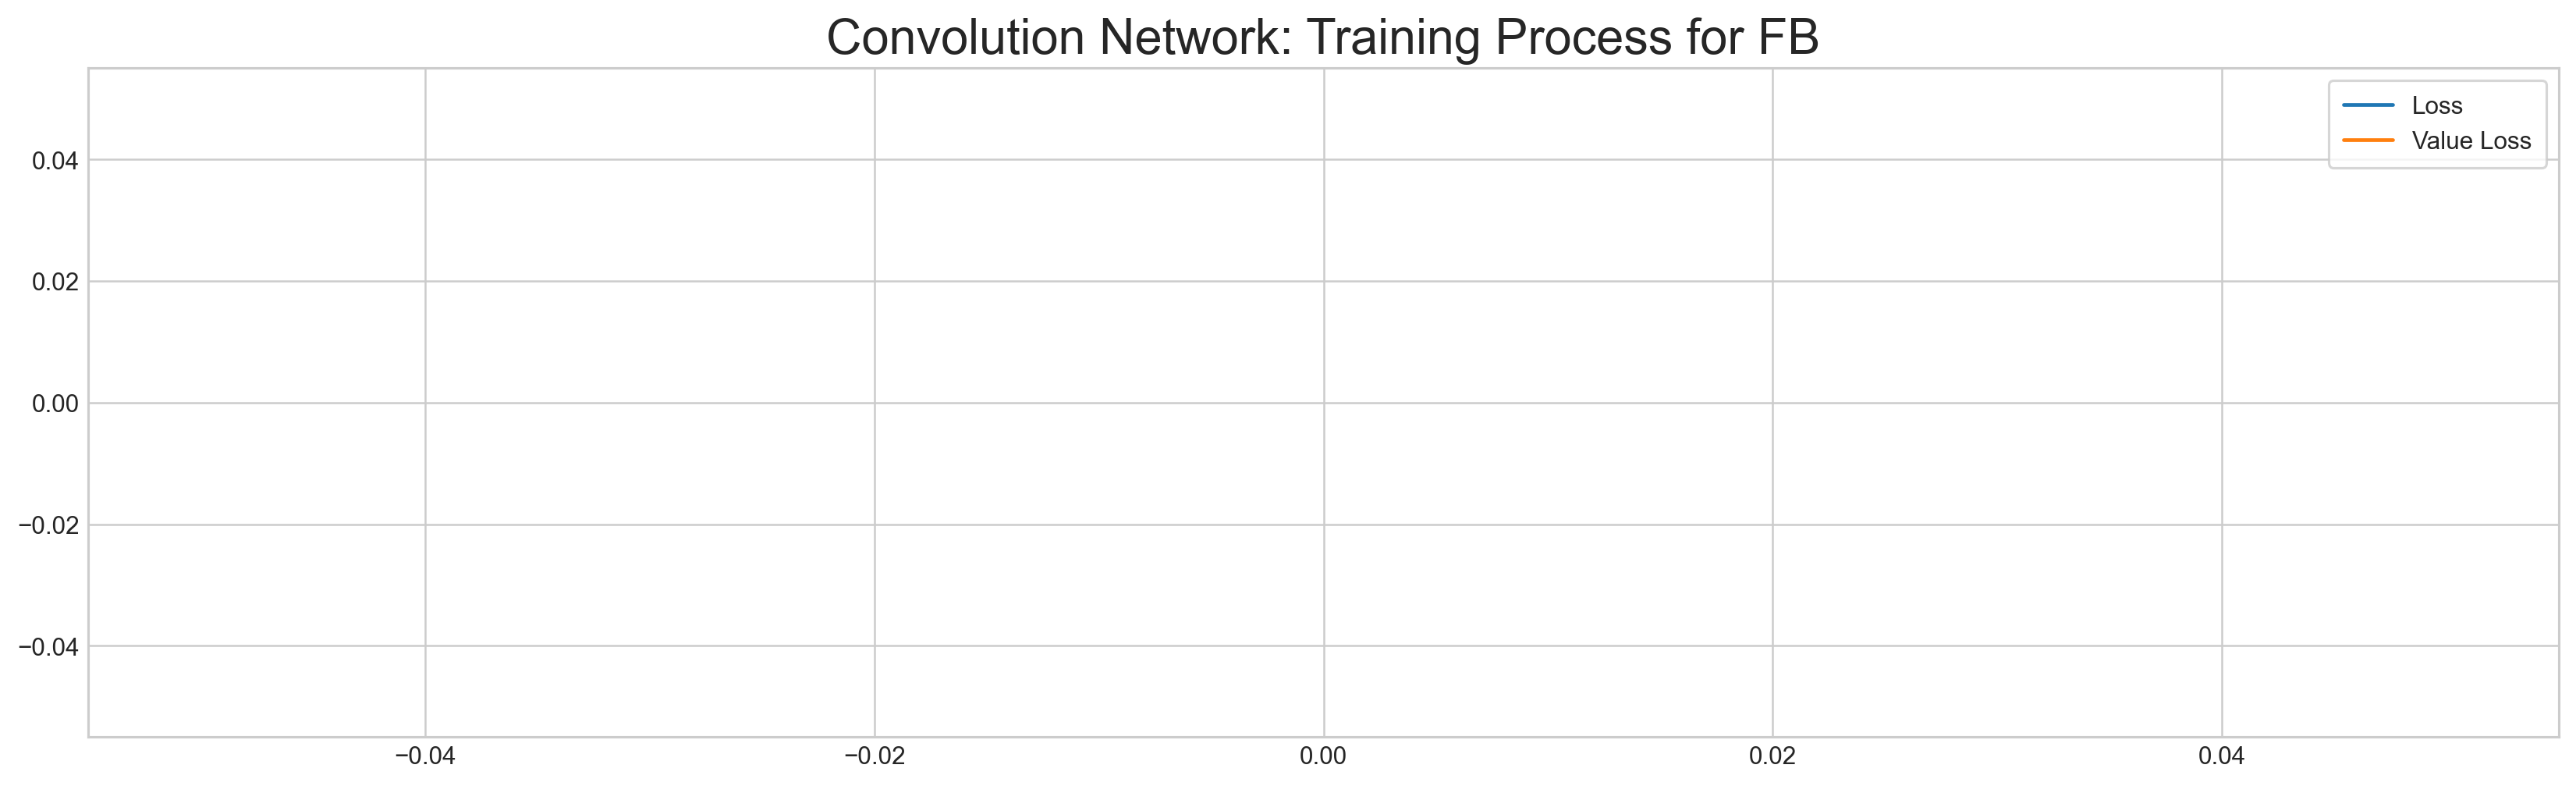

In [75]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(18,5))

plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label="Value Loss")

plt.title("Convolution Network: Training Process for "+ticker.upper(), fontsize=20)
plt.legend(frameon=True, loc=1, borderpad=.6)
plt.show()

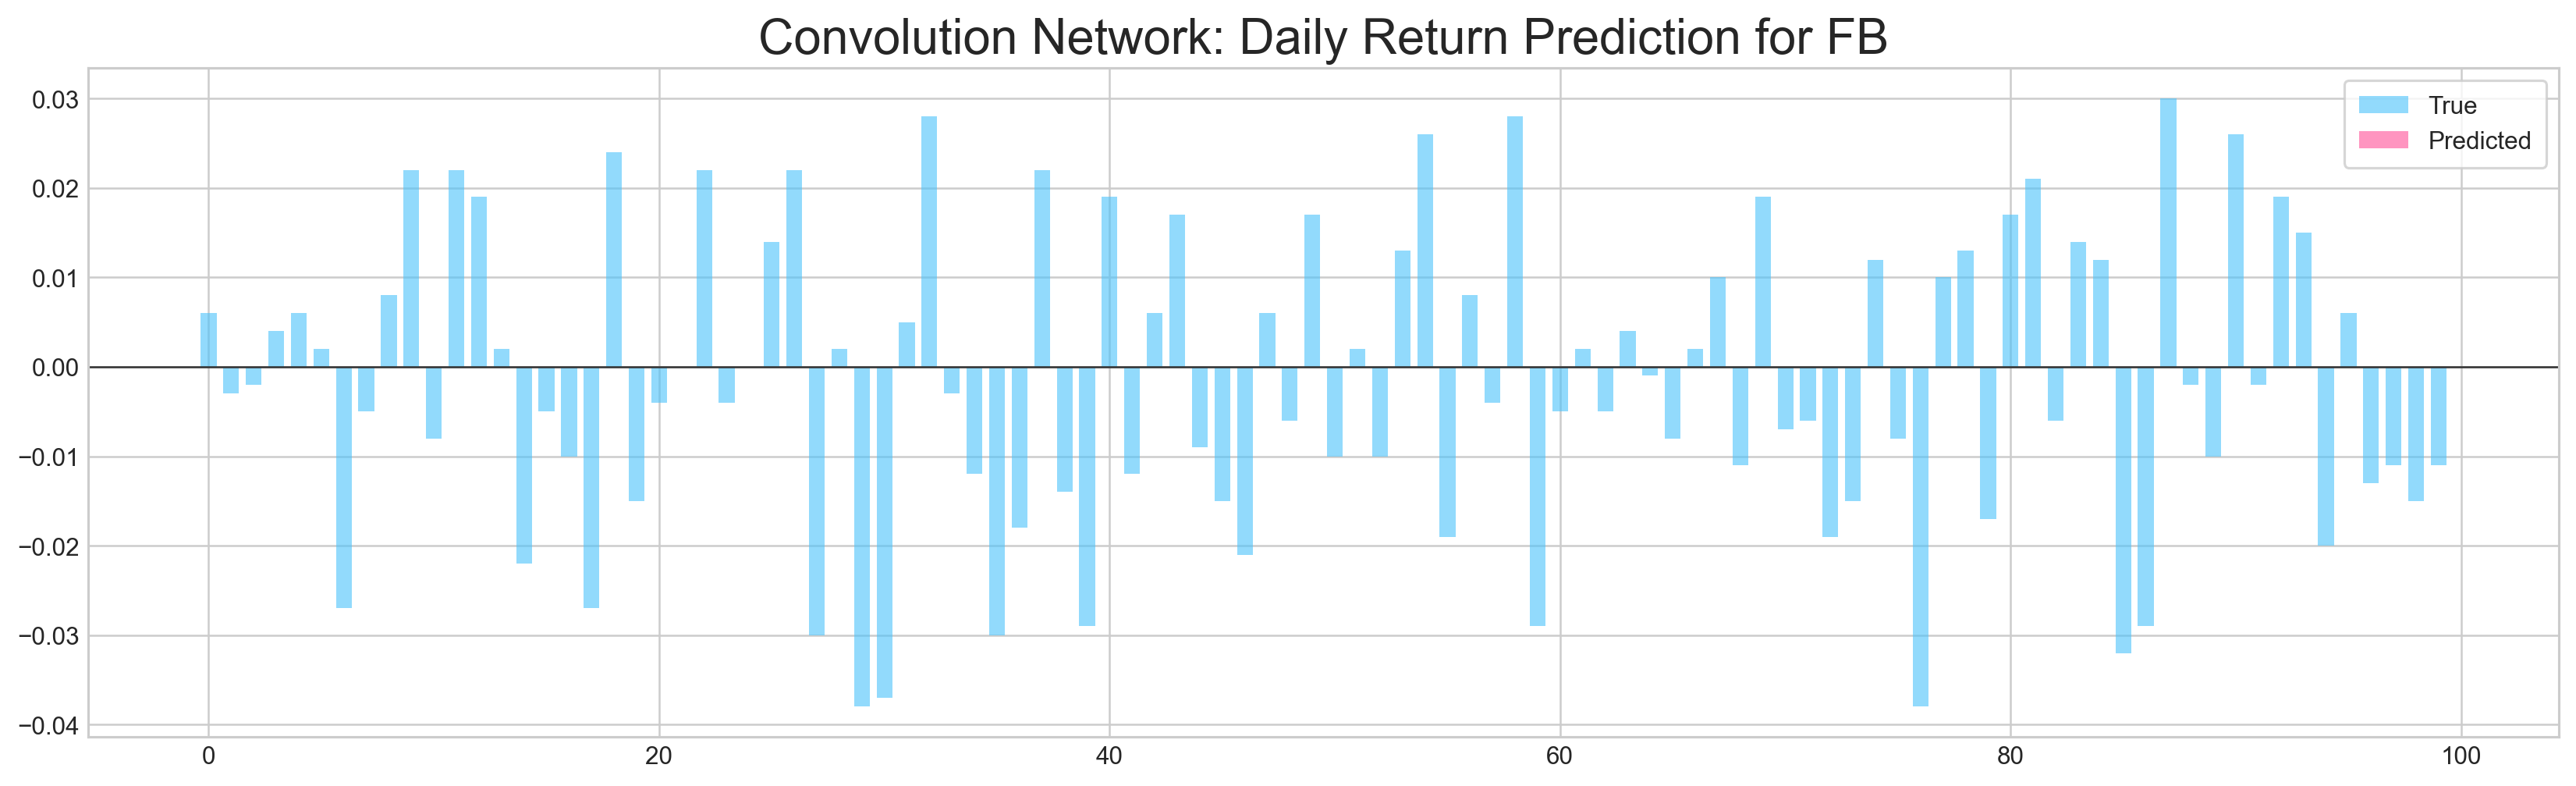

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [76]:
pred, y_true, y_pred = evaluation(X_test, y_test, model, random=True, n_preds=100, show_graph=True)